# AML Fraud Detection
Classification of Frauds using Neural Network

Importing the data from the CSV file stored in the cloud object storage and saving it in the data frame

In [201]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_9ad76f82714e48d7811b2543f2936693 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='LULdO8iN1GZFvjpg50QiRnWJ5P8eKsQXFxJaHODlPJWJ',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_9ad76f82714e48d7811b2543f2936693.get_object(Bucket='dsx-donotdelete-pr-tjck77hosph311',Key='subset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data = pd.read_csv(body)
df_data_1 = df_data[0 : 31057]
df_data_1.tail()



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
31052,95.0,TRANSFER,56745.14,C872526349,56745.14,0.0,C1824885183,0.00,0.00,1.0,0.0
31053,95.0,CASH_OUT,56745.14,C526144262,56745.14,0.0,C79051264,51433.88,108179.02,1.0,0.0
31054,95.0,TRANSFER,33676.59,C732111322,33676.59,0.0,C1140210295,0.00,0.00,1.0,0.0
31055,95.0,CASH_OUT,33676.59,C1000086512,33676.59,0.0,C1759363094,0.00,33676.59,1.0,0.0
31056,95.0,TRANSFER,87999.25,C927181710,87999.25,0.0,C757947873,0.00,0.00,1.0,0.0


Previewing the imported data

In [202]:
print(df_data_1.head())
print(df_data_1.info())



   step     type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   1.0  PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1   1.0  PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2   1.0  PAYMENT  11668.14  C2048537720        41554.0        29885.86   
3   1.0  PAYMENT   7817.71    C90045638        53860.0        46042.29   
4   1.0  PAYMENT   7107.77   C154988899       183195.0       176087.23   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2  M1230701703             0.0             0.0      0.0             0.0  
3   M573487274             0.0             0.0      0.0             0.0  
4   M408069119             0.0             0.0      0.0             0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31057 entries, 0 to 31056
Data columns (total 11 columns):
st

Importing the libraries and defining variables

In [203]:
from keras.layers import Dense
from keras.layers import LSTM, Input
from keras.models import Model
import h5py
from keras.models import Sequential
from keras.layers import Dense, Dropout

batch_size = 10
num_classes = 2
epochs = 10


Data cleansing to remove features not relevant

In [204]:
df = df_data_1.copy()
df.drop('nameOrig', axis=1, inplace=True)
df.drop('nameDest', axis=1, inplace=True)
df.drop('isFlaggedFraud', axis=1, inplace=True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1.0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0.0
1,1.0,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0.0
2,1.0,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0.0
3,1.0,PAYMENT,7817.71,53860.0,46042.29,0.0,0.0,0.0
4,1.0,PAYMENT,7107.77,183195.0,176087.23,0.0,0.0,0.0


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31057 entries, 0 to 31056
Data columns (total 8 columns):
step              31057 non-null float64
type              31057 non-null object
amount            31057 non-null float64
oldbalanceOrg     31057 non-null float64
newbalanceOrig    31057 non-null float64
oldbalanceDest    31057 non-null float64
newbalanceDest    31057 non-null float64
isFraud           31057 non-null float64
dtypes: float64(7), object(1)
memory usage: 1.9+ MB


Histogram of isFraud feature with other features

isFraud
0.0    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
1.0    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
dtype: object

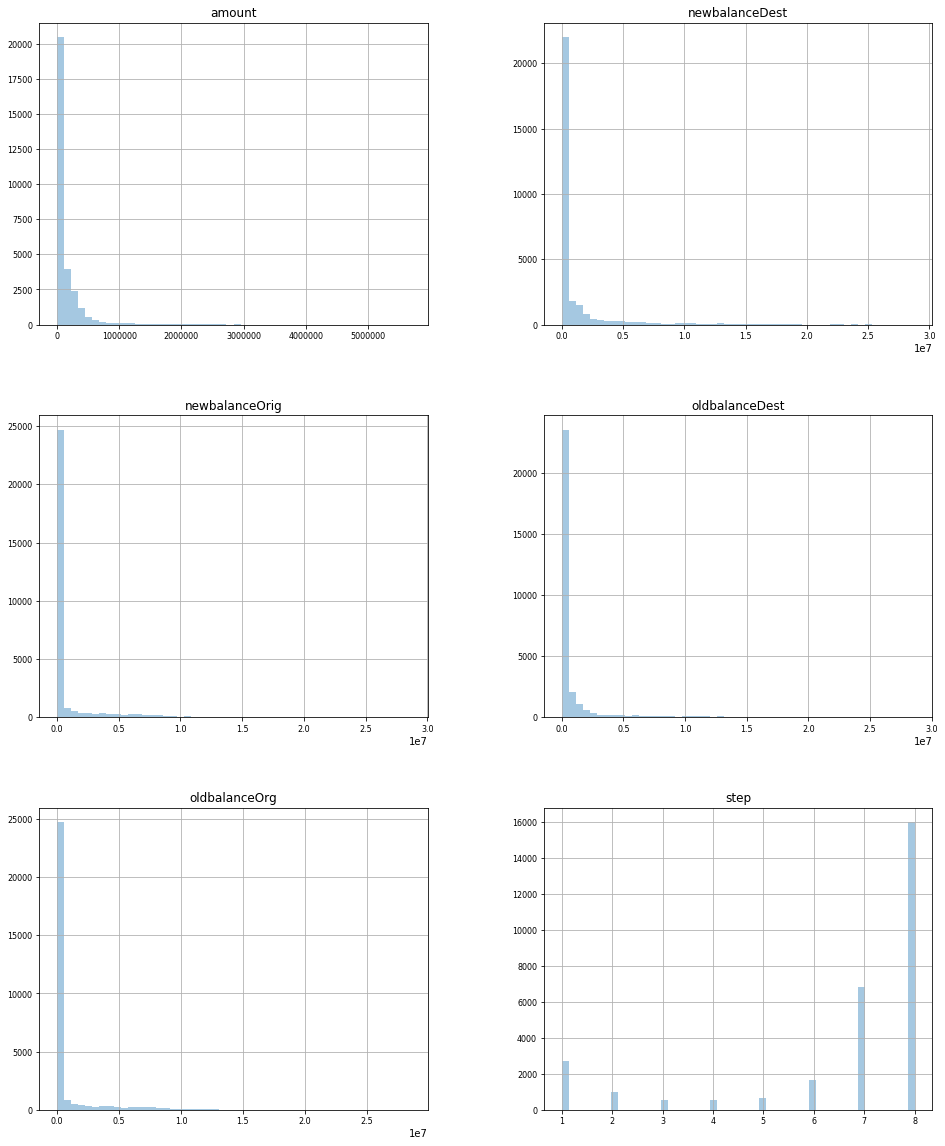

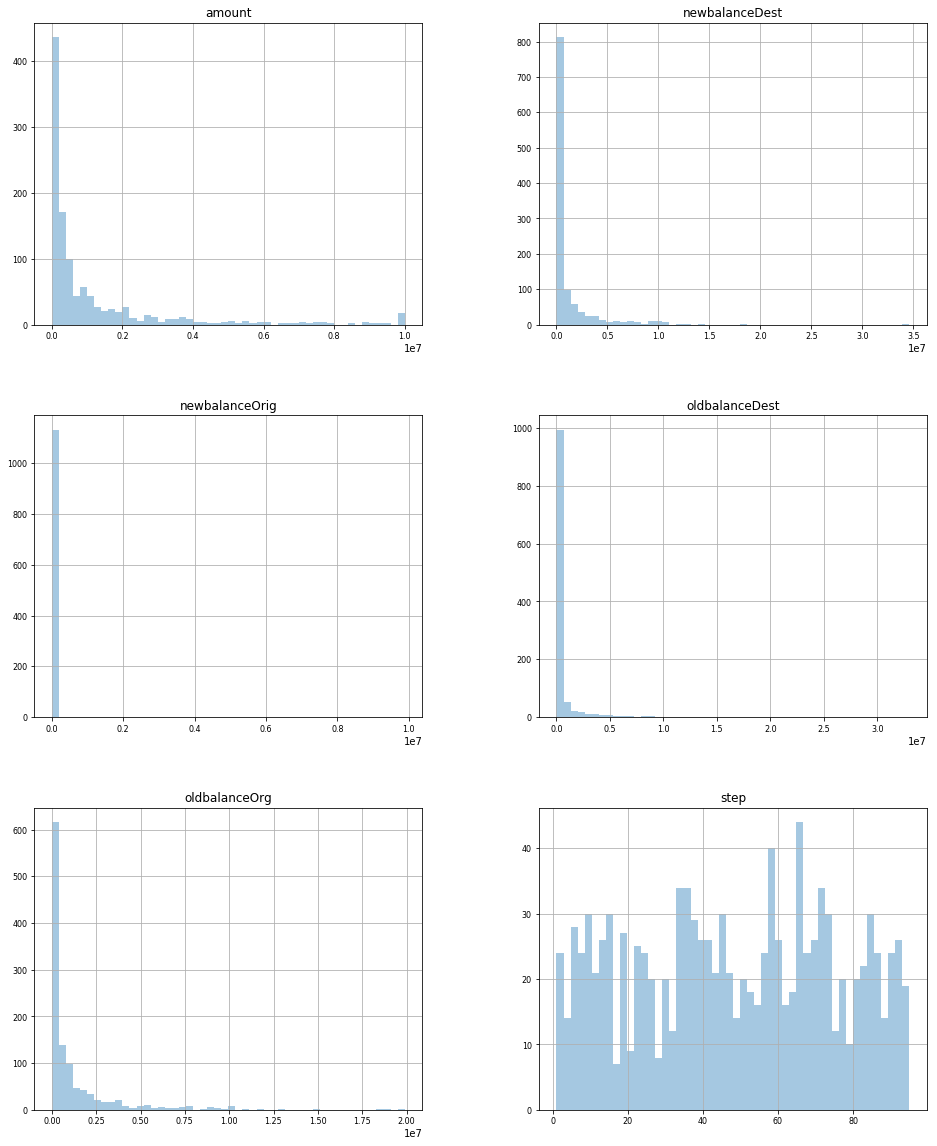

In [206]:
df.groupby('isFraud').hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8,alpha=0.4)

Correlation matrix to check multicolinearity between variables and displaying using SNS package

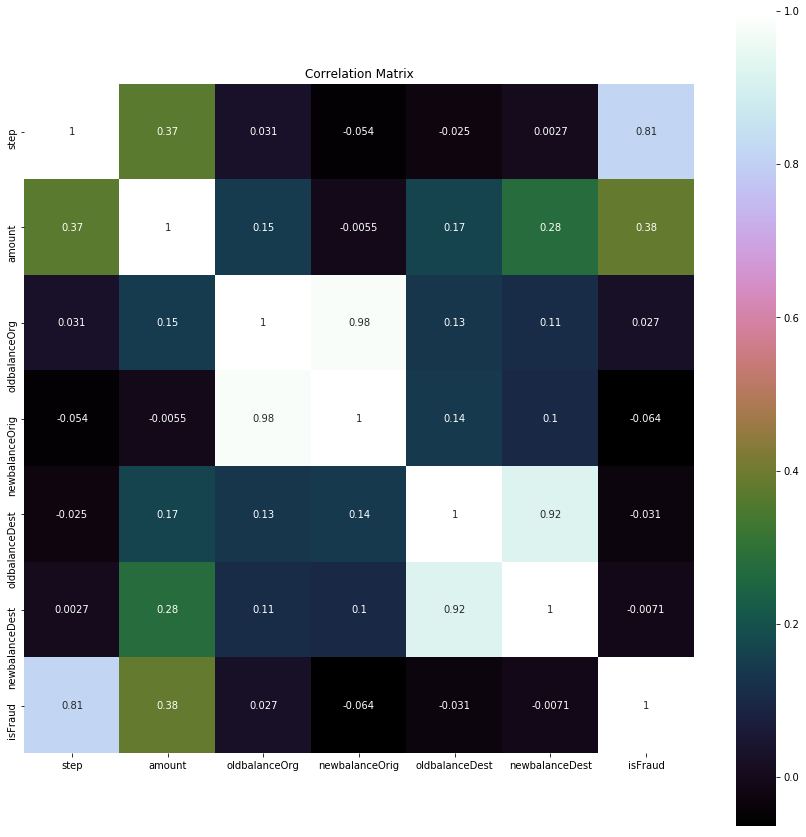

In [207]:
from matplotlib import pyplot as plt
import seaborn as sns

correlation = df.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Creating dummy variables for categorical values and checking the balance of the target class

0.0    29916
1.0     1141
Name: isFraud, dtype: int64


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1.0,9839.64,170136.0,160296.36,0.0,0.0,0.0,0,0,0,1,0
1,1.0,1864.28,21249.0,19384.72,0.0,0.0,0.0,0,0,0,1,0
2,1.0,11668.14,41554.0,29885.86,0.0,0.0,0.0,0,0,0,1,0
3,1.0,7817.71,53860.0,46042.29,0.0,0.0,0.0,0,0,0,1,0
4,1.0,7107.77,183195.0,176087.23,0.0,0.0,0.0,0,0,0,1,0


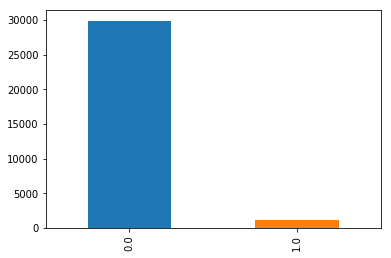

In [368]:
# creating dummy variables for categorical values 

dum = pd.get_dummies(df['type'])
df1 = pd.concat([df,dum],axis=1)
df1.drop(['type'],axis=1, inplace=True)

#checking if target class is balanced or not

#df2 = df1.sample(n=20000)
df2 = df1.copy()  # sample(n=31057)
df2.isFraud.value_counts().plot.bar()
print(df2.isFraud.value_counts())
df2.head()

Splitting the data into training and test

In [369]:
#!pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(df2.drop(['isFraud'],axis=1), df2['isFraud'], test_size=0.3, random_state=0)

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

#resampling the training data

sm = SMOTE(random_state=10, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 779
Before OverSampling, counts of label '0': 20960 

After OverSampling, the shape of train_X: (41920, 11)
After OverSampling, the shape of train_y: (41920,) 

After OverSampling, counts of label '1': 20960
After OverSampling, counts of label '0': 20960


Initializing the sequential model and plotting the training curves

In [532]:
from sklearn.preprocessing import StandardScaler
import numpy as np

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train_res)
x_test_scaled = sc.transform(X_test)

#Initializing the model

model = Sequential()
model.add(Dense(input_shape=(11,), output_dim = 22, init = 'uniform', activation = 'relu'))
model.add(Dense(output_dim = 22, init = 'uniform', activation = 'relu'))
model.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model_info = model.fit(x_train_scaled, y_train_res, batch_size = 64,  nb_epoch = 10)

#batch_size = 64,

Epoch 1/10
41920/41920 [==============================] - 2s 42us/step - loss: 0.1734 - acc: 0.9503
Epoch 2/10
41920/41920 [==============================] - 1s 30us/step - loss: 0.0604 - acc: 0.9780
Epoch 3/10
41920/41920 [==============================] - 1s 30us/step - loss: 0.0546 - acc: 0.9795
Epoch 4/10
41920/41920 [==============================] - 1s 32us/step - loss: 0.0504 - acc: 0.9813
Epoch 5/10
41920/41920 [==============================] - 1s 29us/step - loss: 0.0472 - acc: 0.9821
Epoch 6/10
41920/41920 [==============================] - 1s 31us/step - loss: 0.0442 - acc: 0.9829
Epoch 7/10
41920/41920 [==============================] - 1s 29us/step - loss: 0.0424 - acc: 0.9831
Epoch 8/10
41920/41920 [==============================] - 1s 33us/step - loss: 0.0402 - acc: 0.9843
Epoch 9/10
41920/41920 [==============================] - 1s 32us/step - loss: 0.0386 - acc: 0.9842
Epoch 10/10
41920/41920 [==============================] - 1s 32us/step - loss: 0.0371 - acc: 0.9850

In [533]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 22)                264       
_________________________________________________________________
dense_63 (Dense)             (None, 22)                506       
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 23        
Total params: 793
Trainable params: 793
Non-trainable params: 0
_________________________________________________________________


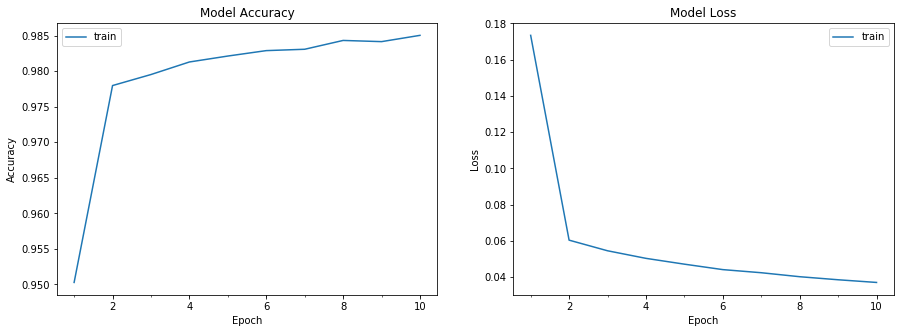

In [534]:
#Plotting the training curves

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    #axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    #axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
plot_model_history(model_info)

'#Predicting the test results 

In [535]:
from sklearn.metrics import accuracy_score

y_pred = model.predict_classes(x_test_scaled)
acc = accuracy_score(y_test,y_pred)*100
print('Accuracy:',round(acc,2))


Accuracy: 99.25


COnfusion matrix

In [536]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


print('Confusion matrix', '\n', confusion_matrix(y_test, y_pred), '\n')
print('Classification report', '\n', classification_report(y_test, y_pred), '\n')


Confusion matrix 
 [[8909   47]
 [  23  339]] 

Classification report 
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      8956
         1.0       0.88      0.94      0.91       362

   micro avg       0.99      0.99      0.99      9318
   macro avg       0.94      0.97      0.95      9318
weighted avg       0.99      0.99      0.99      9318
 



In [537]:
!rm AML_Model_FF_0_1.h5
!rm AML_Model_FF_0_1.tgz
!ls

logs  spark-events  user-libs


Saving the model for API based consumption

In [538]:
save_path = "AML_Model_FF_0_1.h5"
model.save(save_path)


In [539]:
!tar -zcvf AML_Model_FF_0_1.tgz AML_Model_FF_0_1.h5 
!ls

AML_Model_FF_0_1.h5
AML_Model_FF_0_1.h5  AML_Model_FF_0_1.tgz  logs  spark-events  user-libs


In [540]:
#!pip install watson-machine-learning-client

In [541]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

In [542]:
wml_credentials ={
  "apikey": "vVVYZ7BiuTVBGhD8jbvbP6pLydQtkK21EQuAKf4kmlKH",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:eu-gb:a/0500b84bed484c97b162efb1d69c2c5e:1a4e6e5d-d9c5-46c8-af76-cfba2787aaa7::",
  "iam_apikey_name": "auto-generated-apikey-ade30250-41dd-47c2-96d9-1706aa21f1e0",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/0500b84bed484c97b162efb1d69c2c5e::serviceid:ServiceId-a6e6b111-a00a-415c-8f59-4095bef85a0e",
  "instance_id": "1a4e6e5d-d9c5-46c8-af76-cfba2787aaa7",
  "password": "9e3da692-7556-4037-a5ec-b763aeb084da",
  "url": "https://eu-gb.ml.cloud.ibm.com",
  "username": "ade30250-41dd-47c2-96d9-1706aa21f1e0"
}

In [543]:
client = WatsonMachineLearningAPIClient(wml_credentials)

In [544]:
import json

Defining the model properties

In [545]:
model_props = {
    client.repository.ModelMetaNames.AUTHOR_NAME:'imran pachapuri',
    client.repository.ModelMetaNames.AUTHOR_EMAIL: 'imran_pachapuri@gmail.com',
    client.repository.ModelMetaNames.NAME: 'Keras based FF Network',
    client.repository.ModelMetaNames.FRAMEWORK_NAME: 'tensorflow',
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: '1.5',
    client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{"name":"keras","version":"2.1.3"}]
}

#client.repository.ModelMetaNames.FRAMEWORK_NAME: 'tensorflow',

In [546]:
client.deployments.delete("898aec21-3b82-414e-a1c0-fd6c204d7a84")
cdl_uid = client.deployments.list()



----  ----  ----  -----  -------  ---------  -------------
GUID  NAME  TYPE  STATE  CREATED  FRAMEWORK  ARTIFACT TYPE
----  ----  ----  -----  -------  ---------  -------------


In [547]:
published_model = client.repository.store_model(model='AML_Model_FF_0_1.tgz', meta_props=model_props)

In [548]:
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_model_details(published_model_uid)

In [549]:
model_details

{'entity': {'author': {'name': 'imran pachapuri'},
  'deployments': {'count': 0,
   'url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/1a4e6e5d-d9c5-46c8-af76-cfba2787aaa7/published_models/044953a6-c253-4a26-99e0-ba26a8791170/deployments'},
  'evaluation_metrics_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/1a4e6e5d-d9c5-46c8-af76-cfba2787aaa7/published_models/044953a6-c253-4a26-99e0-ba26a8791170/evaluation_metrics',
  'feedback_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/1a4e6e5d-d9c5-46c8-af76-cfba2787aaa7/published_models/044953a6-c253-4a26-99e0-ba26a8791170/feedback',
  'latest_version': {'created_at': '2019-03-02T13:58:04.578Z',
   'guid': 'f4ba4682-3a05-4ccf-970b-e47ae0a23871',
   'url': 'https://eu-gb.ml.cloud.ibm.com/v3/ml_assets/models/044953a6-c253-4a26-99e0-ba26a8791170/versions/f4ba4682-3a05-4ccf-970b-e47ae0a23871'},
  'learning_configuration_url': 'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/1a4e6e5d-d9c5-46c8-af76-cfba2787aaa7/published_models

In [550]:
client.deployments.list() #.delete("157468c3-e67d-4781-8c59-44df2fc4d697")

----  ----  ----  -----  -------  ---------  -------------
GUID  NAME  TYPE  STATE  CREATED  FRAMEWORK  ARTIFACT TYPE
----  ----  ----  -----  -------  ---------  -------------


Model deployment

In [551]:
created_deployment = client.deployments.create(published_model_uid, name="AML_MODEL_01")



#######################################################################################

Synchronous deployment creation for uid: '044953a6-c253-4a26-99e0-ba26a8791170' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='e4129d0d-702e-4aa0-b821-fc48bf7b0a8d'
------------------------------------------------------------------------------------------------




In [552]:
client.deployments.list()

------------------------------------  ------------  ------  --------------  ------------------------  --------------  -------------
GUID                                  NAME          TYPE    STATE           CREATED                   FRAMEWORK       ARTIFACT TYPE
e4129d0d-702e-4aa0-b821-fc48bf7b0a8d  AML_MODEL_01  online  DEPLOY_SUCCESS  2019-03-02T13:58:07.550Z  tensorflow-1.5  model
------------------------------------  ------------  ------  --------------  ------------------------  --------------  -------------


In [553]:
scoring_endpoint = created_deployment['entity']['scoring_url']
print(scoring_endpoint)

https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/1a4e6e5d-d9c5-46c8-af76-cfba2787aaa7/deployments/e4129d0d-702e-4aa0-b821-fc48bf7b0a8d/online


In [554]:

scoring_payload = {"fields": ["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "CASH_IN", "CASH_OUT", "DEBIT", "PAYMENT", "TRANSFER"] ,"values":[1.0, 62610.80, 79114.00, 16503.20, 517.00, 8383.29, 0, 0, 0, 0, 1]}
#scoring_payload = {"value": [1.0, 62610.80, 79114.00, 16503.20, 517.00, 8383.29, 0, 0, 0, 0, 1]}
type(scoring_payload)




dict

Running the prediction against the deployed model (!Not Working)

In [555]:

predictions_test = client.deployments.score(scoring_endpoint, scoring_payload)
print(predictions_test["values"][0][1])

ApiRequestFailure: Failure during scoring. (POST https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/1a4e6e5d-d9c5-46c8-af76-cfba2787aaa7/deployments/e4129d0d-702e-4aa0-b821-fc48bf7b0a8d/online)
Status code: 400, body: {"trace": "c52b3fb8b0f009404983cf0f63626e98", "errors": [{"code": "invalid_input_data", "message": "Incorrect input data: Cannot feed value of shape (11,) for Tensor 'dense_62_input:0', which has shape '(?, 11)'"}], "status_code": 400}
